In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import mnist1d
import random

In [2]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path = './mnist1d_data.pkl', download = False, regenerate=False)

print("Examples in the training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in the training set: 4000
Examples in test set: 1000
Length of each example: 40


In [3]:
# load the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))
     

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


In [4]:
# there are 40 input dimensions
D_i = 40

# the outputs corresponds to 10 digits
D_o = 10

# TODO Create a model with the following layers
# 1. Convolutional layer, (input=length 40 and 1 channel, kernel size 3, stride 2, padding="valid", 15 output channels )
# 2. ReLU
# 3. Convolutional layer, (input=length 19 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels )
# 4. ReLU
# 5. Convolutional layer, (input=length 9 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels)
# 6. ReLU
# 7. Flatten (converts 4x15) to length 60
# 8. Linear layer (input size = 60, output size = 10)

model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=15, kernel_size=3, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=60, out_features=10)
)


In [5]:
# initialize the weights
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)

In [6]:
# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long')).long()

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

Sequential(
  (0): Conv1d(1, 15, kernel_size=(3,), stride=(2,))
  (1): ReLU()
  (2): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (3): ReLU()
  (4): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=60, out_features=10, bias=True)
)

Epoch     0, train loss 2.164831, train error 82.55,  val loss 2.184056, percent error 84.30
Epoch     1, train loss 1.693731, train error 70.60,  val loss 1.712340, percent error 70.90
Epoch     2, train loss 1.421679, train error 57.17,  val loss 1.442641, percent error 61.30
Epoch     3, train loss 1.298841, train error 52.42,  val loss 1.314902, percent error 53.00
Epoch     4, train loss 1.259139, train error 51.47,  val loss 1.276614, percent error 53.40
Epoch     5, train loss 1.127984, train error 46.17,  val loss 1.149209, percent error 48.20
Epoch     6, train loss 1.058261, train error 42.45,  val loss 1.086235, percent error 45.90
Epoch     7, train loss 0.939076, train error 37.88,  val loss 0.973409, percent error 38.90
Epoch     8, train loss 0.875987, train error 35.43,  val loss 0.922793, percent error 37.20
Epoch     9, train loss 0.770597, train error 30.15,  val loss 0.820180, percent error 32.20
Epoch    10, train loss 0.684798, train error 25.90,  val loss 0.75946

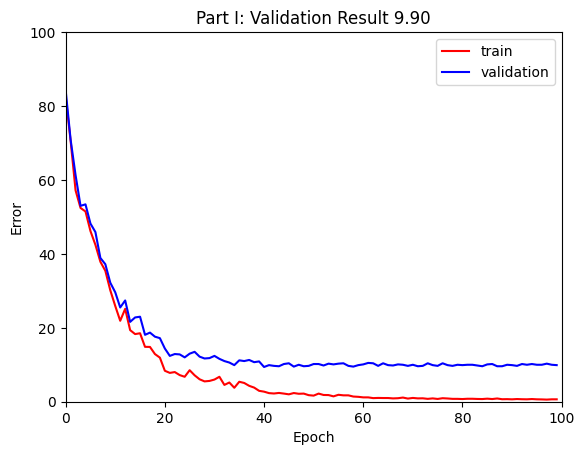

In [7]:
# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
    # loop over batches
    for i, data in enumerate(data_loader):
        # retrieve inputs and labels for this batch
        x_batch, y_batch = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass -- calculate model output
        pred = model(x_batch[:,None,:])
        # compute the loss
        loss = loss_function(pred, y_batch)
        # backward pass
        loss.backward()
        # SGD update
        optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    pred_train = model(x_train[:,None,:])
    pred_val = model(x_val[:,None,:])
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_val_class = torch.max(pred_val.data, 1)
    errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
    losses_train[epoch] = loss_function(pred_train, y_train).item()
    losses_val[epoch]= loss_function(pred_val, y_val).item()
    print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

    # tell scheduler to consider updating learning rate
    scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
plt.show()